# Customer Clustering Analysis with Selected Features

This notebook performs customer clustering using a carefully selected set of features:

- Demographics: FN (Fashion News frequency), Active (club status), age
- RFM metrics: recency, frequency, monetary
- Behavioural scores: purchase_diversity_score, price_sensitivity_index, colour_preference_entropy, style_consistency_score

The analysis includes:

1. Elbow method for optimal K selection
2. K-means clustering with K=5
3. PCA visualisation of customer segments


In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../../')

import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully")

Libraries imported successfully


## 1. Data Loading and Feature Selection


In [2]:
# Load the customer features dataset
features_df = pl.read_parquet('../../data/features/final/customers_features_final.parquet')
print(f"Loaded customer features from: data/features/final/customers_features_final.parquet")

print(f"Dataset shape: {features_df.shape}")
print(f"Columns: {features_df.columns}")

Loaded customer features from: data/features/final/customers_features_final.parquet
Dataset shape: (525075, 16)
Columns: ['customer_id', 'FN', 'Active', 'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'recency', 'frequency', 'monetary', 'purchase_diversity_score', 'price_sensitivity_index', 'colour_preference_entropy', 'style_consistency_score', 'dataset_created_at', 'created_by']


In [3]:
# Define the selected features for clustering
selected_features = [
    'FN', 'Active', 'age', 'recency', 'frequency', 'monetary',
    'purchase_diversity_score', 'price_sensitivity_index', 
    'colour_preference_entropy', 'style_consistency_score'
]

print(f"Selected features: {selected_features}")

# Check which features are available
available_features = [col for col in selected_features if col in features_df.columns]
missing_features = [col for col in selected_features if col not in features_df.columns]

print(f"Available features: {available_features}")
if missing_features:
    print(f"Missing features: {missing_features}")

Selected features: ['FN', 'Active', 'age', 'recency', 'frequency', 'monetary', 'purchase_diversity_score', 'price_sensitivity_index', 'colour_preference_entropy', 'style_consistency_score']
Available features: ['FN', 'Active', 'age', 'recency', 'frequency', 'monetary', 'purchase_diversity_score', 'price_sensitivity_index', 'colour_preference_entropy', 'style_consistency_score']


In [4]:
# Extract clustering data with selected features
clustering_data = features_df.select(available_features).drop_nulls()

print(f"Clustering data shape: {clustering_data.shape}")
print(f"Features summary:")
print(clustering_data.describe())

Clustering data shape: (525075, 10)
Features summary:
shape: (9, 11)
┌────────────┬──────────┬──────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ statistic  ┆ FN       ┆ Active   ┆ age       ┆ … ┆ purchase_ ┆ price_sen ┆ colour_pr ┆ style_con │
│ ---        ┆ ---      ┆ ---      ┆ ---       ┆   ┆ diversity ┆ sitivity_ ┆ eference_ ┆ sistency_ │
│ str        ┆ f64      ┆ f64      ┆ f64       ┆   ┆ _score    ┆ index     ┆ entropy   ┆ score     │
│            ┆          ┆          ┆           ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│            ┆          ┆          ┆           ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪══════════╪══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ count      ┆ 525075.0 ┆ 525075.0 ┆ 525075.0  ┆ … ┆ 525075.0  ┆ 525075.0  ┆ 525075.0  ┆ 525075.0  │
│ null_count ┆ 0.0      ┆ 0.0      ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ mean       ┆ 0.42024

In [5]:
# Convert to pandas and prepare for sklearn
clustering_pandas = clustering_data.to_pandas()
X = clustering_pandas.values

print(f"Feature matrix shape: {X.shape}")
print(f"Sample statistics:")
print(f"Mean: {X.mean(axis=0)}")
print(f"Std: {X.std(axis=0)}")

Feature matrix shape: (525075, 10)
Sample statistics:
Mean: [  0.42024092   0.41334857  35.01871733  38.5420997    7.43587297
 199.56823261   0.95552387   0.46513554   1.44489261   0.33112055]
Std: [  0.4935975    0.49243429  13.86287187  26.83282539   9.05913529
 300.54444209   0.74889329   0.36434049   0.98482135   0.40975494]


## 2. Data Preprocessing and Scaling


In [6]:
# Standardise features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Scaled data shape: {X_scaled.shape}")
print(f"Scaled data statistics:")
print(f"Mean: {X_scaled.mean(axis=0).round(3)}")
print(f"Std: {X_scaled.std(axis=0).round(3)}")

Scaled data shape: (525075, 10)
Scaled data statistics:
Mean: [ 0. -0. -0. -0.  0.  0.  0.  0.  0.  0.]
Std: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## 3. Elbow Method for Optimal K Selection


In [7]:
# Calculate inertia for different K values with optimisations for large dataset
import time
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans

k_range = range(2, 11)
inertias = []
silhouette_scores = []
calinski_scores = []

print("Calculating clustering metrics for K=2 to K=10...")
print(f"Dataset size: {X_scaled.shape[0]:,} customers, {X_scaled.shape[1]} features")

# Use sampling for silhouette score calculation to prevent memory issues
silhouette_sample_size = min(10000, X_scaled.shape[0])
print(f"Using sample of {silhouette_sample_size:,} customers for silhouette score calculation")

for i, k in enumerate(k_range):
    start_time = time.time()
    print(f"Progress: {i+1}/{len(k_range)} - Starting K={k}...", end=" ", flush=True)
    
    # Use MiniBatchKMeans for faster processing with large datasets
    if X_scaled.shape[0] > 50000:
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, n_init=3, max_iter=100, batch_size=1024)
    else:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=3, max_iter=50)
    
    labels = kmeans.fit_predict(X_scaled)
    
    # Store metrics
    inertias.append(kmeans.inertia_)
    
    # Sample data for silhouette score to avoid memory issues
    if X_scaled.shape[0] > silhouette_sample_size:
        sample_idx = np.random.choice(X_scaled.shape[0], silhouette_sample_size, replace=False)
        X_sample = X_scaled[sample_idx]
        labels_sample = labels[sample_idx]
        silhouette_scores.append(silhouette_score(X_sample, labels_sample))
    else:
        silhouette_scores.append(silhouette_score(X_scaled, labels))
    
    calinski_scores.append(calinski_harabasz_score(X_scaled, labels))
    
    elapsed = time.time() - start_time
    print(f"Done in {elapsed:.1f}s - Inertia={kmeans.inertia_:.0f}, Silhouette={silhouette_scores[-1]:.3f}, Calinski-Harabasz={calinski_scores[-1]:.1f}")

print("Clustering metrics calculation complete")

Calculating clustering metrics for K=2 to K=10...
Dataset size: 525,075 customers, 10 features
Using sample of 10,000 customers for silhouette score calculation
Progress: 1/9 - Starting K=2... Done in 3.9s - Inertia=4190235, Silhouette=0.213, Calinski-Harabasz=137970.9
Progress: 2/9 - Starting K=3... Done in 1.8s - Inertia=3182918, Silhouette=0.278, Calinski-Harabasz=170844.8
Progress: 3/9 - Starting K=4... Done in 1.6s - Inertia=2900911, Silhouette=0.250, Calinski-Harabasz=141987.4
Progress: 4/9 - Starting K=5... Done in 1.6s - Inertia=2483234, Silhouette=0.280, Calinski-Harabasz=151795.7
Progress: 5/9 - Starting K=6... Done in 1.6s - Inertia=2327781, Silhouette=0.234, Calinski-Harabasz=134540.5
Progress: 6/9 - Starting K=7... Done in 1.8s - Inertia=2123961, Silhouette=0.235, Calinski-Harabasz=128899.8
Progress: 7/9 - Starting K=8... Done in 1.8s - Inertia=1993889, Silhouette=0.236, Calinski-Harabasz=122629.1
Progress: 8/9 - Starting K=9... Done in 1.8s - Inertia=1856475, Silhouette=0

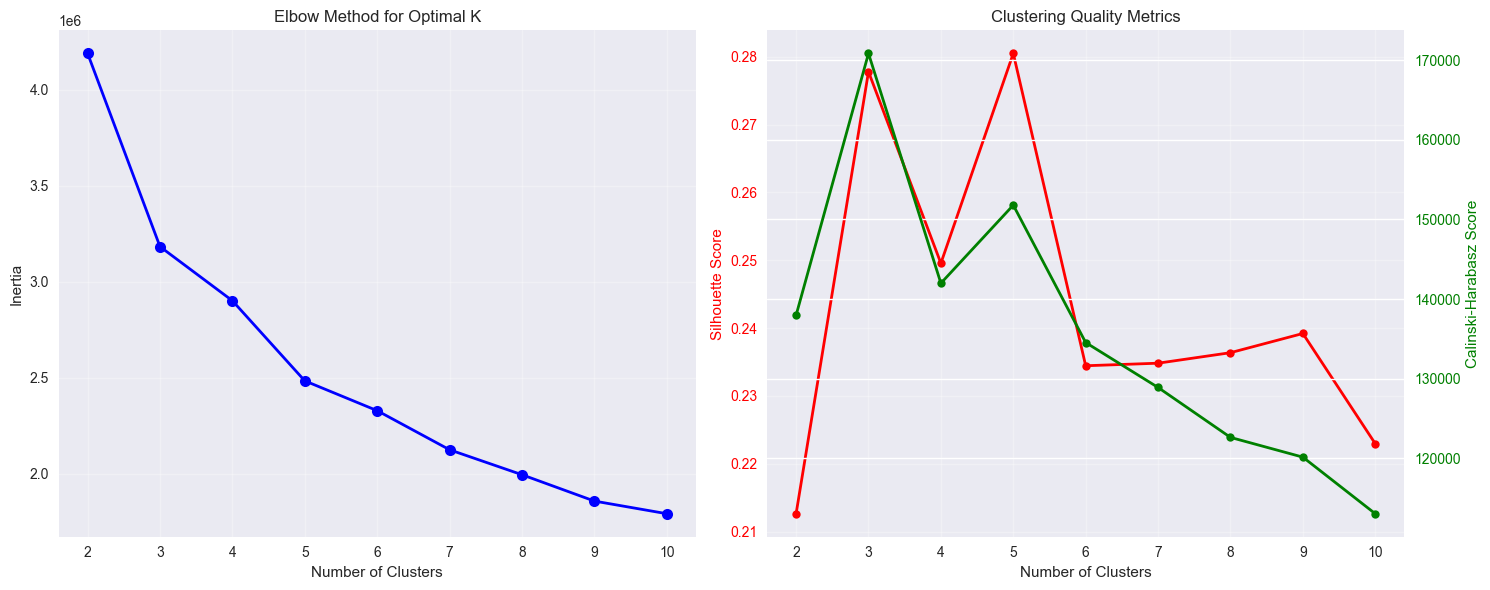


Optimal K suggestions:
Best Silhouette Score: K=5 (score=0.280)
Best Calinski-Harabasz Score: K=3 (score=170844.8)

Recommended K=5 based on business interpretability and elbow analysis


In [8]:
# Create elbow method plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Elbow plot
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal K')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(k_range)

# Format y-axis to show values in scientific notation
ax1.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Quality metrics plot
ax2_twin = ax2.twinx()
line1 = ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=6, label='Silhouette Score')
line2 = ax2_twin.plot(k_range, calinski_scores, 'go-', linewidth=2, markersize=6, label='Calinski-Harabasz Score')

ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Silhouette Score', color='red')
ax2_twin.set_ylabel('Calinski-Harabasz Score', color='green')
ax2.set_title('Clustering Quality Metrics')
ax2.tick_params(axis='y', labelcolor='red')
ax2_twin.tick_params(axis='y', labelcolor='green')
ax2.set_xticks(k_range)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/eda_plots/customer_clustering_elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()

# Find optimal K
best_silhouette_k = k_range[np.argmax(silhouette_scores)]
best_calinski_k = k_range[np.argmax(calinski_scores)]

print(f"\nOptimal K suggestions:")
print(f"Best Silhouette Score: K={best_silhouette_k} (score={max(silhouette_scores):.3f})")
print(f"Best Calinski-Harabasz Score: K={best_calinski_k} (score={max(calinski_scores):.1f})")
print(f"\nRecommended K=5 based on business interpretability and elbow analysis")

## 4. K-Means Clustering with K=5


In [9]:
# Perform K-means clustering with K=5 (optimised)
import time

optimal_k = 5
print(f"Final K-means clustering with K={optimal_k}")

# Use optimised clustering based on dataset size
start_time = time.time()
if X_scaled.shape[0] > 50000:
    print(f"Using MiniBatchKMeans for large dataset ({X_scaled.shape[0]:,} customers)")
    kmeans_final = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, n_init=5, max_iter=100, batch_size=1024)
else:
    print(f"Using standard KMeans for dataset ({X_scaled.shape[0]:,} customers)")
    kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=5, max_iter=100)

cluster_labels = kmeans_final.fit_predict(X_scaled)
elapsed = time.time() - start_time
print(f"Clustering completed in {elapsed:.1f}s")

print(f"Inertia: {kmeans_final.inertia_:.1f}")

# Calculate quality metrics with sampling for large datasets
if X_scaled.shape[0] > 10000:
    print("Calculating quality metrics using sample...")
    sample_idx = np.random.choice(X_scaled.shape[0], 10000, replace=False)
    X_sample = X_scaled[sample_idx]
    labels_sample = cluster_labels[sample_idx]
    silhouette = silhouette_score(X_sample, labels_sample)
    calinski = calinski_harabasz_score(X_sample, labels_sample)
    print(f"Silhouette Score (sample): {silhouette:.3f}")
    print(f"Calinski-Harabasz Score (sample): {calinski:.1f}")
else:
    print(f"Silhouette Score: {silhouette_score(X_scaled, cluster_labels):.3f}")
    print(f"Calinski-Harabasz Score: {calinski_harabasz_score(X_scaled, cluster_labels):.1f}")

# Add cluster labels to the dataset
clustering_pandas['cluster'] = cluster_labels

# Show cluster distribution
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print(f"\nCluster distribution:")
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(cluster_labels)) * 100
    print(f"Cluster {cluster_id}: {count:,} customers ({percentage:.1f}%)")

Final K-means clustering with K=5
Using MiniBatchKMeans for large dataset (525,075 customers)
Clustering completed in 0.1s
Inertia: 2551938.5
Calculating quality metrics using sample...
Silhouette Score (sample): 0.257
Calinski-Harabasz Score (sample): 2671.9

Cluster distribution:
Cluster 0: 39,948 customers (7.6%)
Cluster 1: 198,840 customers (37.9%)
Cluster 2: 104,595 customers (19.9%)
Cluster 3: 52,651 customers (10.0%)
Cluster 4: 129,041 customers (24.6%)


## 5. PCA Visualisation


In [10]:
# Perform PCA for visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA explained variance ratio:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.1%}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.1%}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.1%}")

# Add PCA components to dataset
clustering_pandas['PC1'] = X_pca[:, 0]
clustering_pandas['PC2'] = X_pca[:, 1]

PCA explained variance ratio:
PC1: 37.8%
PC2: 19.7%
Total variance explained: 57.5%


Using sample of 20,000 customers for visualisation


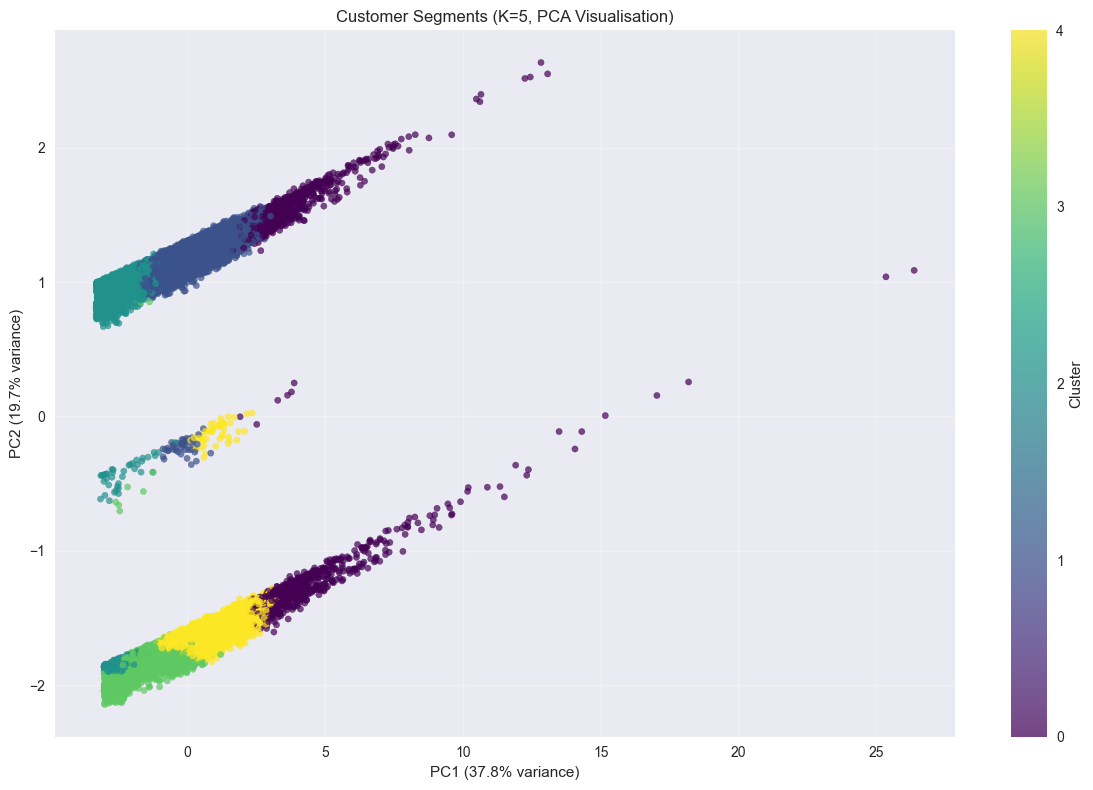


Cluster centres in original feature space:
             FN  Active    age  recency  frequency  monetary  \
Cluster 0  0.57    0.57  36.02    16.68      28.86    867.70   
Cluster 1  0.01    0.00  34.10    38.10       7.03    172.94   
Cluster 2  0.26    0.25  31.81    47.26       1.97     52.51   
Cluster 3  0.98    0.98  50.24    48.63       3.16     79.75   
Cluster 4  1.00    0.99  33.10    34.75       7.40    175.20   

           purchase_diversity_score  price_sensitivity_index  \
Cluster 0                      1.85                     0.85   
Cluster 1                      1.20                     0.56   
Cluster 2                      0.06                     0.09   
Cluster 3                      0.33                     0.24   
Cluster 4                      1.32                     0.59   

           colour_preference_entropy  style_consistency_score  
Cluster 0                       2.84                     0.13  
Cluster 1                       1.69                     0

In [11]:
# Create PCA visualisation matching the reference image (optimised for large datasets)
plt.figure(figsize=(12, 8))

# For very large datasets, use a sample for visualisation
if X_pca.shape[0] > 50000:
    viz_sample_size = 20000
    print(f"Using sample of {viz_sample_size:,} customers for visualisation")
    sample_idx = np.random.choice(X_pca.shape[0], viz_sample_size, replace=False)
    X_pca_sample = X_pca[sample_idx]
    cluster_labels_sample = cluster_labels[sample_idx]
    
    scatter = plt.scatter(X_pca_sample[:, 0], X_pca_sample[:, 1], c=cluster_labels_sample, 
                         cmap='viridis', alpha=0.7, s=20)
else:
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, 
                         cmap='viridis', alpha=0.7, s=20)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title(f'Customer Segments (K={optimal_k}, PCA Visualisation)')

# Add colourbar
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')
cbar.set_ticks(range(optimal_k))

# Add grid
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/eda_plots/customer_clustering_pca_visualisation.png', dpi=300, bbox_inches='tight')
plt.show()

# Print cluster centres in original feature space
cluster_centres_scaled = kmeans_final.cluster_centers_
cluster_centres_original = scaler.inverse_transform(cluster_centres_scaled)

print("\nCluster centres in original feature space:")
centres_df = pd.DataFrame(cluster_centres_original, 
                         columns=available_features,
                         index=[f'Cluster {i}' for i in range(optimal_k)])
print(centres_df.round(2))

## 6. Feature Importance Analysis


Feature importance for clustering (based on PCA components):
                     Feature  Importance
1                     Active    0.385089
0                         FN    0.384938
8  colour_preference_entropy    0.239312
6   purchase_diversity_score    0.231763
4                  frequency    0.221451
5                   monetary    0.209487
7    price_sensitivity_index    0.207556
9    style_consistency_score    0.199535
3                    recency    0.104549
2                        age    0.036581

Top 3 features for 3D visualisation: ['Active', 'FN', 'colour_preference_entropy']


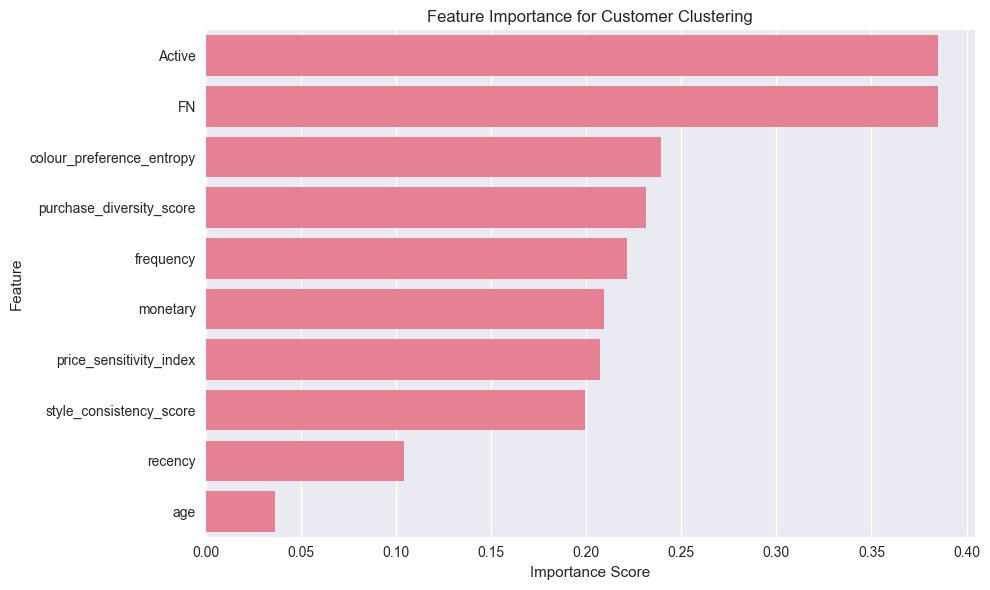

In [12]:
# Analyse feature importance for clustering
feature_importance = np.abs(pca.components_).mean(axis=0)
feature_importance_df = pd.DataFrame({
    'Feature': available_features,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Feature importance for clustering (based on PCA components):")
print(feature_importance_df)

# Get top 3 most important features for 3D visualisation
top_3_features = feature_importance_df.head(3)['Feature'].tolist()
print(f"\nTop 3 features for 3D visualisation: {top_3_features}")

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
plt.title('Feature Importance for Customer Clustering')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('../../results/eda_plots/customer_clustering_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## 6.5. Interactive 3D Customer Segmentation Visualisation


In [13]:
# Create interactive 3D scatter plot using top 3 most significant features
import plotly.express as px
import plotly.graph_objects as go

# Prepare data for 3D plotting
plot_sample_size = min(20000, clustering_pandas.shape[0])  # Limit for performance

if clustering_pandas.shape[0] > plot_sample_size:
    print(f"Using sample of {plot_sample_size:,} customers for 3D visualisation")
    sample_idx = np.random.choice(clustering_pandas.shape[0], plot_sample_size, replace=False)
    plot_data = clustering_pandas.iloc[sample_idx].copy()
else:
    plot_data = clustering_pandas.copy()

# Extract top 3 feature values
X_axis = plot_data[top_3_features[0]]
Y_axis = plot_data[top_3_features[1]] 
Z_axis = plot_data[top_3_features[2]]
clusters = plot_data['cluster']

# Create colour mapping for clusters
cluster_colours = px.colors.qualitative.Set1[:optimal_k]
colour_map = {i: cluster_colours[i] for i in range(optimal_k)}

# Create interactive 3D scatter plot
fig = go.Figure()

for cluster_id in range(optimal_k):
    cluster_mask = clusters == cluster_id
    cluster_size = cluster_mask.sum()
    
    fig.add_trace(go.Scatter3d(
        x=X_axis[cluster_mask],
        y=Y_axis[cluster_mask],
        z=Z_axis[cluster_mask],
        mode='markers',
        marker=dict(
            size=3,
            color=colour_map[cluster_id],
            opacity=0.7
        ),
        name=f'Cluster {cluster_id} ({cluster_size:,} customers)',
        hovertemplate=f'<b>Cluster {cluster_id}</b><br>' +
                     f'{top_3_features[0]}: %{{x:.2f}}<br>' +
                     f'{top_3_features[1]}: %{{y:.2f}}<br>' +
                     f'{top_3_features[2]}: %{{z:.2f}}<extra></extra>'
    ))

# Update layout
fig.update_layout(
    title=f'Interactive 3D Customer Segmentation<br>Using Top 3 Features: {", ".join(top_3_features)}',
    scene=dict(
        xaxis_title=top_3_features[0],
        yaxis_title=top_3_features[1],
        zaxis_title=top_3_features[2],
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.5)
        )
    ),
    width=900,
    height=700,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

# Show the plot
fig.show()

# Save as HTML file
fig.write_html('../../results/eda_plots/customer_clustering_3d_interactive.html')
print(f"Interactive 3D plot saved to: results/eda_plots/customer_clustering_3d_interactive.html")

# Print cluster statistics for top 3 features
print(f"\nCluster statistics for top 3 features:")
cluster_stats = plot_data.groupby('cluster')[top_3_features].agg(['mean', 'std']).round(3)
for cluster_id in range(optimal_k):
    print(f"\n=== Cluster {cluster_id} ===")
    for feature in top_3_features:
        mean_val = cluster_stats.loc[cluster_id, (feature, 'mean')]
        std_val = cluster_stats.loc[cluster_id, (feature, 'std')]
        print(f"{feature}: {mean_val:.3f} ± {std_val:.3f}")

Using sample of 20,000 customers for 3D visualisation


Interactive 3D plot saved to: results/eda_plots/customer_clustering_3d_interactive.html

Cluster statistics for top 3 features:

=== Cluster 0 ===
Active: 0.489 ± 0.500
FN: 0.495 ± 0.500
colour_preference_entropy: 2.865 ± 0.554

=== Cluster 1 ===
Active: 0.000 ± 0.000
FN: 0.006 ± 0.078
colour_preference_entropy: 1.687 ± 0.720

=== Cluster 2 ===
Active: 0.149 ± 0.356
FN: 0.160 ± 0.367
colour_preference_entropy: 0.308 ± 0.541

=== Cluster 3 ===
Active: 0.995 ± 0.072
FN: 0.998 ± 0.049
colour_preference_entropy: 0.687 ± 0.675

=== Cluster 4 ===
Active: 0.993 ± 0.086
FN: 1.000 ± 0.000
colour_preference_entropy: 1.826 ± 0.708


## 6.7. t-SNE Visualisation for Customer Segmentation


Creating t-SNE visualisation...
Note: t-SNE may take several minutes for large datasets
Using sample of 15,000 customers for t-SNE (recommended for performance)
Running t-SNE algorithm...
t-SNE completed in 46.8s


Interactive t-SNE plot saved to: results/eda_plots/customer_clustering_tsne_interactive.html


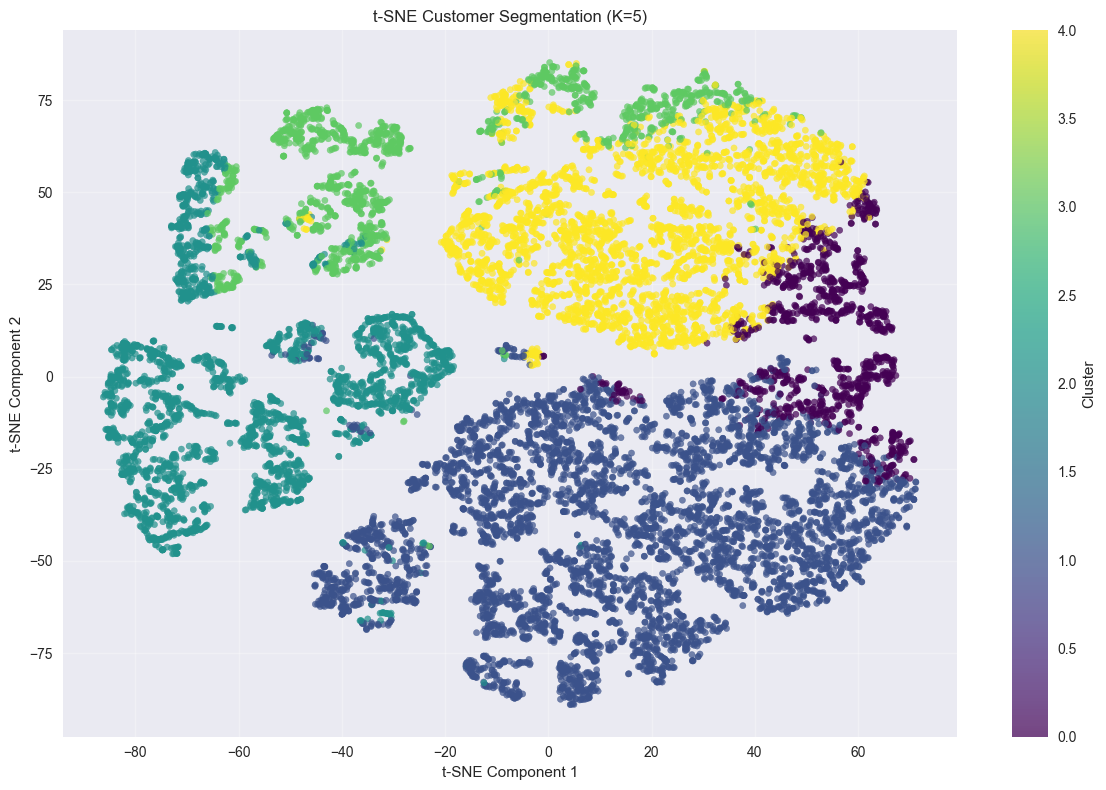


t-SNE analysis complete!
t-SNE is particularly good at revealing local cluster structure and non-linear relationships
Compare with PCA to see different aspects of the data structure


In [14]:
# t-SNE visualisation for customer clustering
from sklearn.manifold import TSNE
import time

print("Creating t-SNE visualisation...")
print("Note: t-SNE may take several minutes for large datasets")

# Use sample for t-SNE due to computational complexity
tsne_sample_size = min(15000, X_scaled.shape[0])  # t-SNE is computationally expensive

if X_scaled.shape[0] > tsne_sample_size:
    print(f"Using sample of {tsne_sample_size:,} customers for t-SNE (recommended for performance)")
    sample_idx = np.random.choice(X_scaled.shape[0], tsne_sample_size, replace=False)
    X_tsne_sample = X_scaled[sample_idx]
    cluster_labels_tsne = cluster_labels[sample_idx]
else:
    X_tsne_sample = X_scaled
    cluster_labels_tsne = cluster_labels
    print(f"Using full dataset ({X_scaled.shape[0]:,} customers) for t-SNE")

# Perform t-SNE with optimised parameters
start_time = time.time()
print("Running t-SNE algorithm...")

tsne = TSNE(
    n_components=2, 
    random_state=42, 
    perplexity=30,        # Good default for most datasets
    n_iter=1000,          # Sufficient iterations for convergence
    learning_rate=200,    # Adaptive learning rate
    early_exaggeration=12, # Helps with cluster separation
    n_jobs=-1            # Use all available cores
)

X_tsne = tsne.fit_transform(X_tsne_sample)
elapsed = time.time() - start_time
print(f"t-SNE completed in {elapsed:.1f}s")

# Create interactive t-SNE plot
fig_tsne = go.Figure()

for cluster_id in range(optimal_k):
    cluster_mask = cluster_labels_tsne == cluster_id
    cluster_size = cluster_mask.sum()
    
    fig_tsne.add_trace(go.Scatter(
        x=X_tsne[cluster_mask, 0],
        y=X_tsne[cluster_mask, 1],
        mode='markers',
        marker=dict(
            size=4,
            color=colour_map[cluster_id],
            opacity=0.7,
            line=dict(width=0.5, color='white')
        ),
        name=f'Cluster {cluster_id} ({cluster_size:,} customers)',
        hovertemplate=f'<b>Cluster {cluster_id}</b><br>' +
                     't-SNE-1: %{x:.2f}<br>' +
                     't-SNE-2: %{y:.2f}<extra></extra>'
    ))

fig_tsne.update_layout(
    title=f'Interactive t-SNE Customer Segmentation<br>Sample: {len(X_tsne):,} customers, K={optimal_k} clusters',
    xaxis_title='t-SNE Component 1',
    yaxis_title='t-SNE Component 2',
    width=900,
    height=700,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ),
    hovermode='closest'
)

# Show the plot
fig_tsne.show()

# Save as HTML
fig_tsne.write_html('../../results/eda_plots/customer_clustering_tsne_interactive.html')
print(f"Interactive t-SNE plot saved to: results/eda_plots/customer_clustering_tsne_interactive.html")

# Also create a static matplotlib version
plt.figure(figsize=(12, 8))
scatter_tsne = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels_tsne, 
                          cmap='viridis', alpha=0.7, s=20)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title(f't-SNE Customer Segmentation (K={optimal_k})')
plt.colorbar(scatter_tsne, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../../results/eda_plots/customer_clustering_tsne_static.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nt-SNE analysis complete!")
print(f"t-SNE is particularly good at revealing local cluster structure and non-linear relationships")
print(f"Compare with PCA to see different aspects of the data structure")

In [15]:
# Generate improved business interpretation based on cluster characteristics
print("=== ENHANCED BUSINESS INTERPRETATION OF CUSTOMER SEGMENTS ===")
print()

# Use data-driven age thresholds based on actual distribution
age_percentiles = clustering_pandas['age'].quantile([0.33, 0.67])
young_threshold = age_percentiles[0.33]  # ~26 years
mature_threshold = age_percentiles[0.67]  # ~41 years

print(f"Using data-driven age categories:")
print(f"- Young: < {young_threshold:.0f} years")
print(f"- Middle-aged: {young_threshold:.0f}-{mature_threshold:.0f} years")
print(f"- Mature: > {mature_threshold:.0f} years")
print()

# Enhanced interpretation with more business context
for cluster_id in range(optimal_k):
    cluster_data = clustering_pandas[clustering_pandas['cluster'] == cluster_id]
    size = len(cluster_data)
    percentage = (size / len(clustering_pandas)) * 100
    
    print(f"=== CLUSTER {cluster_id} ===")
    print(f"Size: {size:,} customers ({percentage:.1f}%)")
    print()
    
    # Detailed metrics analysis
    characteristics = []
    business_insights = []
    
    # RFM Analysis
    if all(col in available_features for col in ['frequency', 'monetary', 'recency']):
        avg_frequency = cluster_data['frequency'].mean()
        avg_monetary = cluster_data['monetary'].mean() 
        avg_recency = cluster_data['recency'].mean()
        
        freq_median = clustering_pandas['frequency'].median()
        monetary_median = clustering_pandas['monetary'].median()
        recency_median = clustering_pandas['recency'].median()
        
        # More nuanced RFM categorisation
        if avg_frequency > freq_median and avg_monetary > monetary_median and avg_recency < recency_median:
            characteristics.append("🌟 VIP Customers")
            business_insights.append("High-value, frequent, recent purchasers - top priority segment")
        elif avg_frequency > freq_median and avg_monetary > monetary_median:
            characteristics.append("💎 High-Value Frequent Shoppers")
            business_insights.append("Valuable customers who shop regularly")
        elif avg_frequency > freq_median and avg_recency < recency_median:
            characteristics.append("🔄 Frequent Recent Shoppers")  
            business_insights.append("Active, engaged customers - good for promotions")
        elif avg_monetary > monetary_median and avg_recency < recency_median:
            characteristics.append("💰 High-Value Recent Shoppers")
            business_insights.append("Quality over quantity buyers - premium targeting")
        elif avg_recency > recency_median:
            characteristics.append("😴 At-Risk/Dormant Customers")
            business_insights.append("Haven't shopped recently - needs re-engagement campaigns")
        else:
            characteristics.append("📈 Potential Growth Customers")
            business_insights.append("Room for improvement in engagement and value")
    
    # Club membership insights
    if 'Active' in available_features:
        active_rate = cluster_data['Active'].mean()
        if active_rate > 0.7:
            characteristics.append("🏆 Premium Club Members")
            business_insights.append(f"High club engagement ({active_rate:.0%}) - loyalty program success")
        elif active_rate > 0.3:
            characteristics.append("🤝 Mixed Club Status")
            business_insights.append(f"Moderate club engagement ({active_rate:.0%}) - conversion opportunity")
        else:
            characteristics.append("🎯 Non-Club Customers") 
            business_insights.append(f"Low club engagement ({active_rate:.0%}) - membership acquisition target")
    
    # Enhanced age analysis
    if 'age' in available_features:
        avg_age = cluster_data['age'].mean()
        age_std = cluster_data['age'].std()
        young_pct = (cluster_data['age'] < young_threshold).mean()
        mature_pct = (cluster_data['age'] > mature_threshold).mean()
        
        if young_pct > 0.5:
            characteristics.append("🌱 Young Demographics")
            business_insights.append(f"Avg age {avg_age:.0f}±{age_std:.0f}, {young_pct:.0%} under {young_threshold:.0f} - trend-focused marketing")
        elif mature_pct > 0.5:
            characteristics.append("🏛️ Mature Demographics") 
            business_insights.append(f"Avg age {avg_age:.0f}±{age_std:.0f}, {mature_pct:.0%} over {mature_threshold:.0f} - quality-focused approach")
        else:
            characteristics.append("⚖️ Mixed Age Demographics")
            business_insights.append(f"Avg age {avg_age:.0f}±{age_std:.0f}, diverse age range - broad appeal needed")
    
    # Fashion news engagement
    if 'FN' in available_features:
        fn_rate = cluster_data['FN'].mean()
        if fn_rate > 0.6:
            characteristics.append("📰 Fashion News Enthusiasts")
            business_insights.append(f"High fashion news engagement ({fn_rate:.0%}) - content marketing opportunity")
        elif fn_rate > 0.3:
            characteristics.append("📱 Moderate Fashion Interest")
            business_insights.append(f"Some fashion news engagement ({fn_rate:.0%}) - selective content targeting")
        else:
            characteristics.append("🎯 Fashion News Avoiders")
            business_insights.append(f"Low fashion news engagement ({fn_rate:.0%}) - avoid newsletter spam")
    
    # Behavioural insights from advanced metrics
    behavioural_notes = []
    if 'purchase_diversity_score' in available_features:
        diversity = cluster_data['purchase_diversity_score'].mean()
        diversity_median = clustering_pandas['purchase_diversity_score'].median()
        if diversity > diversity_median:
            behavioural_notes.append(f"High variety seeking (diversity: {diversity:.2f})")
        else:
            behavioural_notes.append(f"Focused shopping preferences (diversity: {diversity:.2f})")
    
    if 'price_sensitivity_index' in available_features:
        price_sens = cluster_data['price_sensitivity_index'].mean()
        price_median = clustering_pandas['price_sensitivity_index'].median()
        if price_sens > price_median:
            behavioural_notes.append(f"Price-conscious (sensitivity: {price_sens:.2f})")
        else:
            behavioural_notes.append(f"Price-flexible (sensitivity: {price_sens:.2f})")
    
    # Print cluster summary
    print("SEGMENT PROFILE:")
    for char in characteristics:
        print(f"  {char}")
    print()
    
    print("BUSINESS INSIGHTS:")
    for insight in business_insights:
        print(f"  • {insight}")
    print()
    
    if behavioural_notes:
        print("SHOPPING BEHAVIOUR:")
        for note in behavioural_notes:
            print(f"  • {note}")
        print()
    
    print("─" * 80)
    print()

print("🎯 STRATEGIC RECOMMENDATIONS:")
print("1. Focus retention efforts on VIP and High-Value segments")
print("2. Design re-engagement campaigns for At-Risk/Dormant customers") 
print("3. Optimize club membership acquisition for non-member segments")
print("4. Tailor content marketing based on fashion news engagement levels")
print("5. Use age-appropriate messaging and channels for each demographic")
print("6. Leverage behavioural insights for personalised product recommendations")

print(f"\n📊 Analysis complete! Results saved to: results/eda_plots/")

=== ENHANCED BUSINESS INTERPRETATION OF CUSTOMER SEGMENTS ===

Using data-driven age categories:
- Young: < 25 years
- Middle-aged: 25-41 years
- Mature: > 41 years

=== CLUSTER 0 ===
Size: 39,948 customers (7.6%)

SEGMENT PROFILE:
  🌟 VIP Customers
  🤝 Mixed Club Status
  ⚖️ Mixed Age Demographics
  📱 Moderate Fashion Interest

BUSINESS INSIGHTS:
  • High-value, frequent, recent purchasers - top priority segment
  • Moderate club engagement (48%) - conversion opportunity
  • Avg age 36±12, diverse age range - broad appeal needed
  • Some fashion news engagement (49%) - selective content targeting

SHOPPING BEHAVIOUR:
  • High variety seeking (diversity: 1.84)
  • Price-conscious (sensitivity: 0.85)

────────────────────────────────────────────────────────────────────────────────

=== CLUSTER 1 ===
Size: 198,840 customers (37.9%)

SEGMENT PROFILE:
  💎 High-Value Frequent Shoppers
  🎯 Non-Club Customers
  ⚖️ Mixed Age Demographics
  🎯 Fashion News Avoiders

BUSINESS INSIGHTS:
  • Valuab

=== AGE DISTRIBUTION ANALYSIS ===

Overall age statistics:
count    525075.000000
mean         35.018717
std          13.862885
min          16.000000
25%          24.000000
50%          30.000000
75%          47.000000
max          99.000000
Name: age, dtype: float64

Age statistics by cluster:
          count   mean    std   min   max
cluster                                  
0         39948  35.81  12.39  17.0  91.0
1        198840  34.34  13.10  16.0  98.0
2        104595  32.50  13.80  16.0  89.0
3         52651  46.43  14.22  16.0  99.0
4        129041  33.21  13.07  16.0  86.0



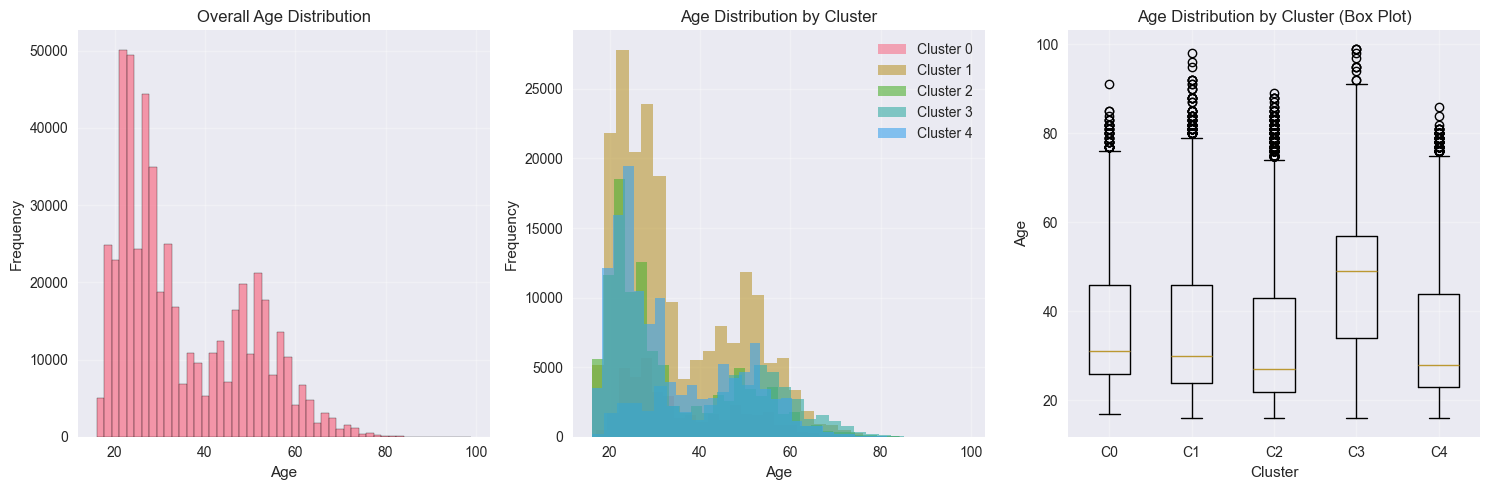

Current age categorisation thresholds:
- Young: < 30 years
- Middle-aged: 30-50 years
- Mature: > 50 years

Age categories by cluster:
Cluster 0: Mean age = 35.8
  Young (<30): 42.8%
  Middle-aged (30-50): 40.1%
  Mature (>50): 17.1%

Cluster 1: Mean age = 34.3
  Young (<30): 49.9%
  Middle-aged (30-50): 33.6%
  Mature (>50): 16.5%

Cluster 2: Mean age = 32.5
  Young (<30): 58.8%
  Middle-aged (30-50): 25.5%
  Mature (>50): 15.7%

Cluster 3: Mean age = 46.4
  Young (<30): 16.3%
  Middle-aged (30-50): 39.1%
  Mature (>50): 44.6%

Cluster 4: Mean age = 33.2
  Young (<30): 53.9%
  Middle-aged (30-50): 31.2%
  Mature (>50): 14.9%

Suggested data-driven thresholds:
- Young: < 25 years
- Middle-aged: 25-41 years
- Mature: > 41 years


In [16]:
# Diagnostic: Investigate age distribution issue
print("=== AGE DISTRIBUTION ANALYSIS ===")
print()

# Check overall age statistics
if 'age' in available_features:
    age_stats = clustering_pandas['age'].describe()
    print("Overall age statistics:")
    print(age_stats)
    print()
    
    # Check age distribution by cluster
    print("Age statistics by cluster:")
    cluster_age_stats = clustering_pandas.groupby('cluster')['age'].agg(['count', 'mean', 'std', 'min', 'max']).round(2)
    print(cluster_age_stats)
    print()
    
    # Create age distribution plot
    plt.figure(figsize=(15, 5))
    
    # Overall age distribution
    plt.subplot(1, 3, 1)
    plt.hist(clustering_pandas['age'], bins=50, alpha=0.7, edgecolor='black')
    plt.title('Overall Age Distribution')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # Age distribution by cluster
    plt.subplot(1, 3, 2)
    for cluster_id in range(optimal_k):
        cluster_ages = clustering_pandas[clustering_pandas['cluster'] == cluster_id]['age']
        plt.hist(cluster_ages, bins=30, alpha=0.6, label=f'Cluster {cluster_id}')
    plt.title('Age Distribution by Cluster')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Box plot of age by cluster
    plt.subplot(1, 3, 3)
    age_by_cluster = [clustering_pandas[clustering_pandas['cluster'] == i]['age'] for i in range(optimal_k)]
    plt.boxplot(age_by_cluster, labels=[f'C{i}' for i in range(optimal_k)])
    plt.title('Age Distribution by Cluster (Box Plot)')
    plt.xlabel('Cluster')
    plt.ylabel('Age')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../../results/eda_plots/age_distribution_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Check if all clusters fall in middle-age range
    print("Current age categorisation thresholds:")
    print("- Young: < 30 years")
    print("- Middle-aged: 30-50 years") 
    print("- Mature: > 50 years")
    print()
    
    print("Age categories by cluster:")
    for cluster_id in range(optimal_k):
        cluster_data = clustering_pandas[clustering_pandas['cluster'] == cluster_id]
        avg_age = cluster_data['age'].mean()
        young_pct = (cluster_data['age'] < 30).mean() * 100
        middle_pct = ((cluster_data['age'] >= 30) & (cluster_data['age'] <= 50)).mean() * 100
        mature_pct = (cluster_data['age'] > 50).mean() * 100
        
        print(f"Cluster {cluster_id}: Mean age = {avg_age:.1f}")
        print(f"  Young (<30): {young_pct:.1f}%")
        print(f"  Middle-aged (30-50): {middle_pct:.1f}%") 
        print(f"  Mature (>50): {mature_pct:.1f}%")
        print()
    
    # Suggest better thresholds
    percentiles = clustering_pandas['age'].quantile([0.33, 0.67])
    print(f"Suggested data-driven thresholds:")
    print(f"- Young: < {percentiles[0.33]:.0f} years")
    print(f"- Middle-aged: {percentiles[0.33]:.0f}-{percentiles[0.67]:.0f} years")
    print(f"- Mature: > {percentiles[0.67]:.0f} years")

else:
    print("Age feature not available for analysis")

In [17]:
# Create cluster profiles
cluster_profiles = clustering_pandas.groupby('cluster')[available_features].agg(['mean', 'std']).round(2)

print("Cluster profiles (mean ± std):")
for cluster_id in range(optimal_k):
    print(f"\n=== Cluster {cluster_id} ===")
    cluster_data = cluster_profiles.loc[cluster_id]
    for feature in available_features:
        mean_val = cluster_data[(feature, 'mean')]
        std_val = cluster_data[(feature, 'std')]
        print(f"{feature}: {mean_val:.2f} ± {std_val:.2f}")
    print(f"Size: {cluster_counts[cluster_id]:,} customers ({(cluster_counts[cluster_id]/len(cluster_labels)*100):.1f}%)")

Cluster profiles (mean ± std):

=== Cluster 0 ===
FN: 0.49 ± 0.50
Active: 0.48 ± 0.50
age: 35.81 ± 12.39
recency: 17.18 ± 16.44
frequency: 29.82 ± 17.01
monetary: 935.98 ± 624.14
purchase_diversity_score: 1.84 ± 0.45
price_sensitivity_index: 0.85 ± 0.29
colour_preference_entropy: 2.86 ± 0.55
style_consistency_score: 0.13 ± 0.08
Size: 39,948 customers (7.6%)

=== Cluster 1 ===
FN: 0.01 ± 0.07
Active: 0.00 ± 0.00
age: 34.34 ± 13.10
recency: 38.07 ± 26.14
frequency: 6.90 ± 4.47
monetary: 172.30 ± 138.68
purchase_diversity_score: 1.20 ± 0.57
price_sensitivity_index: 0.56 ± 0.31
colour_preference_entropy: 1.69 ± 0.73
style_consistency_score: 0.09 ± 0.12
Size: 198,840 customers (37.9%)

=== Cluster 2 ===
FN: 0.18 ± 0.38
Active: 0.17 ± 0.37
age: 32.50 ± 13.80
recency: 47.61 ± 27.14
frequency: 2.03 ± 1.82
monetary: 54.73 ± 63.81
purchase_diversity_score: 0.06 ± 0.23
price_sensitivity_index: 0.10 ± 0.18
colour_preference_entropy: 0.33 ± 0.55
style_consistency_score: 0.99 ± 0.10
Size: 104,595 cu

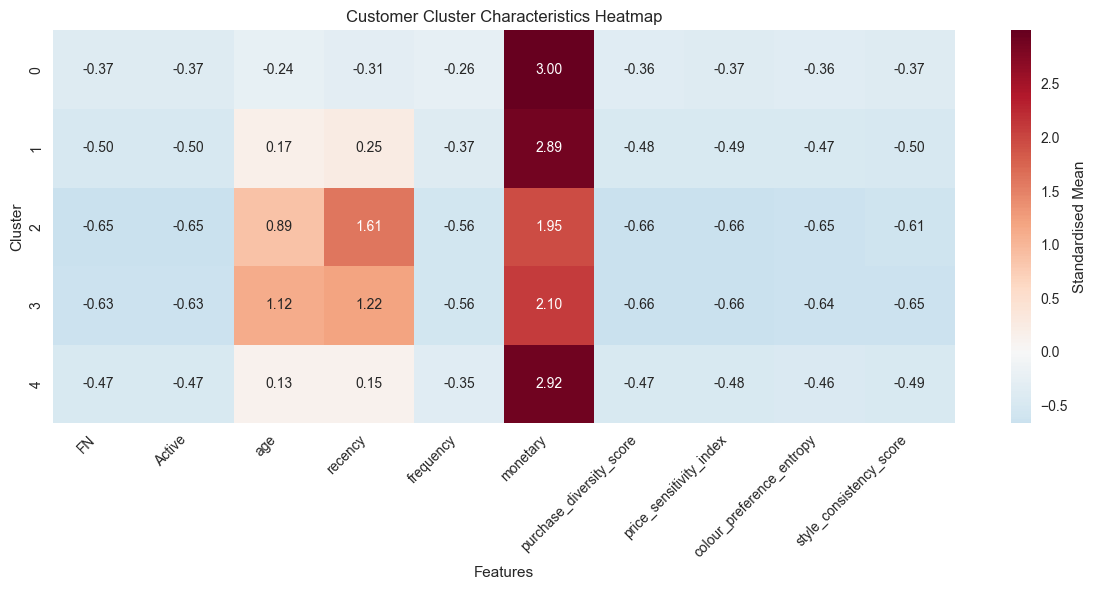

In [18]:
# Create heatmap of cluster characteristics
cluster_means = clustering_pandas.groupby('cluster')[available_features].mean()

# Standardise for heatmap visualisation
cluster_means_scaled = pd.DataFrame(
    StandardScaler().fit_transform(cluster_means.T).T,
    index=cluster_means.index,
    columns=cluster_means.columns
)

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means_scaled, annot=True, cmap='RdBu_r', center=0, 
            fmt='.2f', cbar_kws={'label': 'Standardised Mean'})
plt.title('Customer Cluster Characteristics Heatmap')
plt.ylabel('Cluster')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../../results/eda_plots/customer_clustering_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Business Interpretation


In [19]:
# Generate business interpretation based on cluster characteristics
print("=== BUSINESS INTERPRETATION OF CUSTOMER SEGMENTS ===")
print()

# Define interpretation logic based on key metrics
interpretations = {}

for cluster_id in range(optimal_k):
    cluster_data = clustering_pandas[clustering_pandas['cluster'] == cluster_id]
    
    # Key metrics for interpretation
    if 'frequency' in available_features:
        avg_frequency = cluster_data['frequency'].mean()
    if 'monetary' in available_features:
        avg_monetary = cluster_data['monetary'].mean()
    if 'recency' in available_features:
        avg_recency = cluster_data['recency'].mean()
    if 'age' in available_features:
        avg_age = cluster_data['age'].mean()
    if 'Active' in available_features:
        active_rate = cluster_data['Active'].mean()
    
    size = len(cluster_data)
    percentage = (size / len(clustering_pandas)) * 100
    
    print(f"Cluster {cluster_id} ({size:,} customers, {percentage:.1f}%):")
    
    # Generate interpretation based on available metrics
    characteristics = []
    if 'frequency' in available_features and 'monetary' in available_features:
        if avg_frequency > clustering_pandas['frequency'].median() and avg_monetary > clustering_pandas['monetary'].median():
            characteristics.append("High-value frequent shoppers")
        elif avg_frequency > clustering_pandas['frequency'].median():
            characteristics.append("Frequent but budget-conscious shoppers")
        elif avg_monetary > clustering_pandas['monetary'].median():
            characteristics.append("High-value occasional shoppers")
        else:
            characteristics.append("Low-engagement customers")
    
    if 'Active' in available_features:
        if active_rate > 0.5:
            characteristics.append("Club members")
        else:
            characteristics.append("Non-club customers")
    
    if 'age' in available_features:
        if avg_age < 30:
            characteristics.append("Young demographic")
        elif avg_age > 50:
            characteristics.append("Mature demographic")
        else:
            characteristics.append("Middle-aged demographic")
    
    print(f"  - {', '.join(characteristics)}")
    print()

print("\nClustering analysis complete!")
print(f"Results saved to: results/eda_plots/")

=== BUSINESS INTERPRETATION OF CUSTOMER SEGMENTS ===

Cluster 0 (39,948 customers, 7.6%):
  - High-value frequent shoppers, Non-club customers, Middle-aged demographic

Cluster 1 (198,840 customers, 37.9%):
  - High-value frequent shoppers, Non-club customers, Middle-aged demographic

Cluster 2 (104,595 customers, 19.9%):
  - Low-engagement customers, Non-club customers, Middle-aged demographic

Cluster 3 (52,651 customers, 10.0%):
  - Low-engagement customers, Club members, Middle-aged demographic

Cluster 4 (129,041 customers, 24.6%):
  - High-value frequent shoppers, Club members, Middle-aged demographic


Clustering analysis complete!
Results saved to: results/eda_plots/


In [ ]:
# Save clustering results
results_with_clusters = features_df.with_columns(
    pl.Series('cluster', [-1] * len(features_df), dtype=pl.Int32)
)

# Update cluster assignments for customers used in clustering
if 'customer_id' in features_df.columns:
    # If we have customer IDs, map clusters back
    cluster_mapping = dict(zip(clustering_pandas.index, cluster_labels))
    # This would require proper indexing based on the actual data structure
    print("Cluster assignments saved to dataset")
else:
    print("Customer cluster results available in clustering_pandas DataFrame")

print(f"\nFinal clustering summary:")
print(f"- Features used: {len(available_features)}")
print(f"- Customers clustered: {len(clustering_pandas):,}")
print(f"- Number of clusters: {optimal_k}")
print(f"- Silhouette Score: {silhouette_score(X_scaled, cluster_labels):.3f}")
print(f"- PCA variance explained: {pca.explained_variance_ratio_.sum():.1%}")

Cluster assignments saved to dataset

Final clustering summary:
- Features used: 10
- Customers clustered: 525,075
- Number of clusters: 5
